# QAOA MacCut_Pennylane(Adam+Rosalin)

I decide to try do do weighted max cut on the penylane because i whant to test more otimizerz ant Pennylate turorial require just some little ajutment to alow us ad weight to the edges. 

In [6]:
import networkx as nx
import numpy as np

from matplotlib import pyplot as plt

import pennylane as qml

from pennylane import numpy as np

In [7]:
np.random.seed(50)

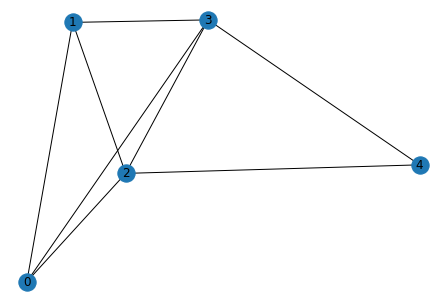

In [8]:
nr_nodes=5
n_wires = nr_nodes
graph = [(0,1,1.0),(1,2,9.0),(0,2,7.0),(3,1,5),(2,3,3.0),(0,3,1.0),(4,3,1),(4,2,1)]
G=nx.Graph()
G.add_weighted_edges_from(graph)
nx.draw(G,with_labels=True)

In [9]:
#brut force  for verification  :
def brut_MaxCut(graph,nr_nodes):
    
    W=np.zeros((int(nr_nodes),int(nr_nodes)))
    for i in graph:
        W[i[0]][i[1]]=i[2]
        W[i[1]][i[0]]=i[2]       


    best_cost_brute=0
    max_str=[]
    maxim=0
    for b in range(2**nr_nodes):
        x=[int(t) for t in reversed(list(bin(b)[2:].zfill(nr_nodes)))]
        cost=0
        for i in range(nr_nodes):
            for j in range(nr_nodes):
                cost=cost+W[i,j]*x[i]*(1-x[j])

        
        if best_cost_brute==cost:
            max_str.append(str(x))
            
        if best_cost_brute<cost:
            best_cost_brute=cost
            max_str=[]
            max_str.append(str(x))
 
            
    return  max_str, best_cost_brute
            
#Example:#      
max_str, best_cost= brut_MaxCut(graph,nr_nodes)  
print("Best cut (cost={}): \n ".format(best_cost))
for i in max_str:
    print(i)

Best cut (cost=24.0): 
 
[0, 0, 1, 1, 0]
[1, 1, 0, 0, 1]


I use the same form for UB and UC as in Maxcut_01  RZ between two C not ais eqivalent have the form :

In [10]:
def UB_01(beta,n_wires):
    for wire in range(n_wires):
        qml.RX(2 * beta, wires=wire)
        
def UC_01(gamma,graph):
    for edge in graph:
        
        wire1=edge[0]
        wire2=edge[1]
        w=edge[2]
        
        qml.CNOT(wires=[wire1, wire2])
        qml.RZ(-w*gamma, wires=wire2)
        qml.CNOT(wires=[wire1, wire2])
        
        
def Init_H(n_wires):
    for wire in range(n_wires):
        qml.Hadamard(wires=wire)

These isa an interesting and thing about pennylane the wey that measurements are created.

In [11]:
def comp_basis_measurement(wires):
    n_wires = len(wires)
    return qml.Hermitian(np.diag(range(2 ** n_wires)), wires=wires)

Partea d emai sus e echivalenta cu calculul costului in cost_2

In [12]:
pauli_z = [[1, 0], [0, -1]]
pauli_z_2 = np.kron(pauli_z, pauli_z)

dev = qml.device("default.qubit", wires=n_wires, analytic=True, shots=1)

@qml.qnode(dev)
def circuit(gammas, betas,n_wires,graph, edge=None, l=1):

    Init_H(n_wires)
    
    for i in range(l):
        UC_01(gammas[i],graph)
        UB_01(betas[i],n_wires)
        
    if edge is None:
        return qml.sample(comp_basis_measurement(range(n_wires)))
    
    return qml.expval(qml.Hermitian(pauli_z_2, wires=(edge[0],edge[1])))  # 1 circuit for eatc edge ?? sems not very practical

In [13]:
def cost(params,l,n_wires,graph,):
    gammas = params[0]
    betas = params[1]
    cost = 0
    for edge in graph:
        # objective for the MaxCut problem
        cost -= 0.5 * (1 - edge[2]*circuit(gammas, betas,n_wires=n_wires,graph=graph, edge=edge, l=l))
    return cost

In [ ]:
def qaoa_maxcut(graph,n_wires,l=1,steps=30,n_samples = 100):
    print("\n number of layers ={:d}".format(l))

    # initialize the parameters near zero
    init_params = 0.01 * np.random.rand(2, l)
  
    # initialize optimizer: Adagrad works well empirically
    opt = qml.AdamOptimizer(stepsize=0.5)
    
    # optimize parameters in cost
    params = init_params
    c_hist=[]
    for i in range(steps):
        params = opt.step(cost, params,n_wires=n_wires,graph=graph,l=l)
        if (i + 1) % 5 == 0:
            c= cost(params,n_wires=n_wires,graph=graph,l=l)
            c_hist.append(c)
            print("-Cost after step {:5d}: {: .7f}".format(i + 1,c))

    bit_strings = []
    for i in range(0, n_samples):
        bit_strings.append(int(circuit(params[0], params[1], n_wires=n_wires,graph=graph, edge=None, l=l)))

    # print optimal parameters and most frequently sampled bitstring
    counts = np.bincount(np.array(bit_strings))
    most_freq_bit_string = np.argmax(counts)
    print("Optimized (gamma, beta) vectors:\n{}".format(params[:, :l]))
    print("Most frequently sampled bit string is: {:04b}".format(most_freq_bit_string))

    return c_hist,-cost(params,n_wires=n_wires,graph=graph,l=l), bit_strings


# perform qaoa on our graph with p=1,2 and
# keep the bitstring sample lists
c_hist1,params1,bitstrings1 = qaoa_maxcut(graph,nr_nodes,l=1,steps=120,n_samples = 100)
c_hist2,params2,bitstrings2 = qaoa_maxcut(graph,nr_nodes,l=2,steps=120,n_samples = 100)


 number of layers =1
-Cost after step     5: -7.2746459
-Cost after step    10: -6.7351591
-Cost after step    15: -7.9653913
-Cost after step    20: -8.6335588
-Cost after step    25: -8.4313790
-Cost after step    30: -8.5544848
-Cost after step    35: -8.7488883
-Cost after step    40: -8.8397638
-Cost after step    45: -8.8682999
-Cost after step    50: -8.8616580
-Cost after step    55: -8.8658379
-Cost after step    60: -8.8878537
-Cost after step    65: -8.8997084
-Cost after step    70: -8.8934649
-Cost after step    75: -8.8986010
-Cost after step    80: -8.8983487
-Cost after step    85: -8.8998444
-Cost after step    90: -8.8992888
-Cost after step    95: -8.8999184
-Cost after step   100: -8.9001729
-Cost after step   105: -8.9002826
-Cost after step   110: -8.9002419
-Cost after step   115: -8.9002729
-Cost after step   120: -8.9002780
Optimized (gamma, beta) vectors:
[[0.42487307]
 [0.68811924]]
Most frequently sampled bit string is: 0101

 number of layers =2


In [15]:
##### Example:#      
max_str, best_cost= brut_MaxCut(graph,nr_nodes)  
print("Best cut (cost={}): \n ".format(best_cost))
for i in max_str:
    print(i)

Best cut (cost=24.0): 
 
[0, 0, 1, 1, 0]
[1, 1, 0, 0, 1]


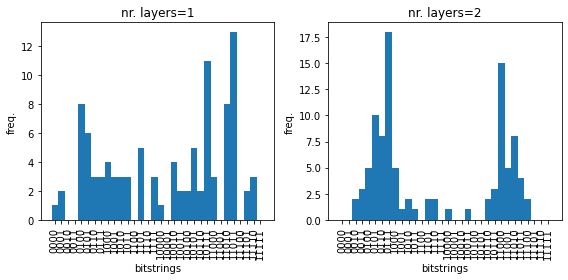

In [16]:
xticks = range(0, 2**nr_nodes)
xtick_labels = list(map(lambda x: format(x, "04b"), xticks))
bins = np.arange(0, 2**nr_nodes+1) - 0.5

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.title("nr. layers=1")
plt.xlabel("bitstrings")
plt.ylabel("freq.")
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(bitstrings1, bins=bins)
plt.subplot(1, 2, 2)
plt.title("nr. layers=2")
plt.xlabel("bitstrings")
plt.ylabel("freq.")
plt.xticks(xticks, xtick_labels, rotation="vertical")
plt.hist(bitstrings2, bins=bins)
plt.tight_layout()
plt.show()

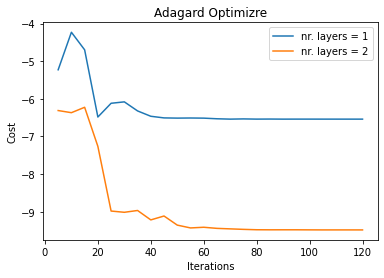

Best possibel scor: -24.0


In [17]:
it=[]
c=5
c1=[]
for i in c_hist1:
    c1.append(float(i.numpy()))
    it.append(c)
    c=c+5
c2=[]
for i in c_hist2:
    c2.append(i.numpy())

plt.title("Adagard Optimizre")
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.plot(it,c1,label="nr. layers = 1")
plt.plot(it,c2,label="nr. layers = 2")
x=[0,it[-1]]
y=[-best_cost,-best_cost]
#plt.plot(x,y)
plt.legend(loc = 'best')
plt.show()

print("Best possibel scor:",-best_cost)

In [18]:
## Some test with more leyers:
c_hist3,params3,bitstrings3 = qaoa_maxcut(graph,nr_nodes,l=3,steps=170,n_samples = 200)
c_hist4,params4,bitstrings4 = qaoa_maxcut(graph,nr_nodes,l=4,steps=170,n_samples = 200)
c_hist5,params5,bitstrings5 = qaoa_maxcut(graph,nr_nodes,l=4,steps=170,n_samples = 200)


 number of layers =3
-Cost after step     5: -5.7237845
-Cost after step    10: -6.4902027
-Cost after step    15: -6.9420157
-Cost after step    20: -8.5576773
-Cost after step    25: -7.7305094
-Cost after step    30: -9.6786349
-Cost after step    35: -9.5595865
-Cost after step    40: -10.1833802
-Cost after step    45: -10.8138635
-Cost after step    50: -10.9298528
-Cost after step    55: -10.9750446
-Cost after step    60: -10.9903565
-Cost after step    65: -10.9879081
-Cost after step    70: -11.0377899
-Cost after step    75: -11.0247654
-Cost after step    80: -11.0271872
-Cost after step    85: -11.0164386
-Cost after step    90: -10.8468768
-Cost after step    95: -11.0350505
-Cost after step   100: -10.5957118
-Cost after step   105: -10.0213936
-Cost after step   110: -10.5778648
-Cost after step   115: -9.8279017
-Cost after step   120: -8.2879571
-Cost after step   125: -9.1512366
-Cost after step   130: -10.4068076
-Cost after step   135: -9.6242418
-Cost after step 

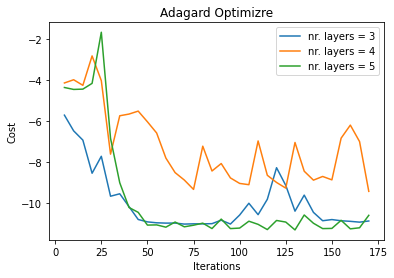

Best possibel scor: -24.0


In [19]:
it=[]
c=5
c3=[]
for i in c_hist3:
    c3.append(float(i.numpy()))
    it.append(c)
    c=c+5
c4=[]
for i in c_hist4:
    c4.append(i.numpy())
c5=[]
for i in c_hist5:
    c5.append(i.numpy())
    
plt.title("Adagard Optimizre")
plt.xlabel("Iterations")
plt.ylabel("Cost")
plt.plot(it,c3,label="nr. layers = 3")
plt.plot(it,c4,label="nr. layers = 4")
plt.plot(it,c5,label="nr. layers = 5")

x=[0,it[-1]]
y=[-best_cost,-best_cost]
#plt.plot(x,y)
plt.legend(loc = 'best')
plt.show()

print("Best possibel scor:",-best_cost)

Pare ca intradevar numarul mai mare de straturi creste acuratetea dar converge mai greu . Orcicum atea e partea frumasa de data asta ne intereseaza doar sa ajungem intr-o stare atat de joasa incat sistemul sa colapseze predominant intr-o pozitie in care costul taieturiilor e maxim ! 

In [20]:
nr_nodes=5
n_wires = nr_nodes
graph = [(0,1,1.0),(1,2,9.0),(0,2,7.0),(3,1,5),(2,3,3.0),(0,3,1.0),(4,3,1),(4,2,1)]

In [21]:
class Rosalin:

    def __init__(self, qnodes, coeffs, min_shots, mu=0.99, b=1e-6, lr=0.07):
        self.qnodes = qnodes
        self.coeffs = coeffs

        self.lipschitz = np.sum(np.abs(coeffs))

        if lr > 2 / self.lipschitz:
            raise ValueError("The learning rate must be less than ", 2 / self.lipschitz)

        # hyperparameters
        self.min_shots = min_shots
        self.mu = mu  # running average constant
        self.b = b    # regularization bias
        self.lr = lr  # learning rate

        # keep track of the total number of shots used
        self.shots_used = 0
        # total number of iterations
        self.k = 0
        # Number of shots per parameter
        self.s = np.zeros_like(params, dtype=np.float64) + min_shots

        # Running average of the parameter gradients
        self.chi = None
        # Running average of the variance of the parameter gradients
        self.xi = None

    def estimate_hamiltonian(self, params, shots):
        """Returns an array containing length ``shots`` single-shot estimates
        of the Hamiltonian. The shots are distributed randomly over
        the terms in the Hamiltonian, as per a Multinomial distribution.

        Since we are performing single-shot estimates, the QNodes must be
        set to 'sample' mode.
        """

        # determine the shot probability per term
        prob_shots = np.abs(coeffs) / np.sum(np.abs(coeffs))

        # construct the multinomial distribution, and sample
        # from it to determine how many shots to apply per term
        si = multinomial(n=shots, p=prob_shots)
        shots_per_term = si.rvs()[0]

        results = []
        for h, c, p, s in zip(self.qnodes, self.coeffs, prob_shots, shots_per_term):

            # if the number of shots is 0, do nothing
            if s == 0:
                continue

            # set the QNode device shots
            h.device.shots = s

            # evaluate the QNode corresponding to
            # the Hamiltonian term
            res = h(params)

            if s == 1:
                res = np.array([res])

            # Note that, unlike above, we divide each term by the
            # probability per shot. This is because we are sampling one at a time.
            results.append(c * res / p)

        return np.concatenate(results)

    def evaluate_grad_var(self, i, params, shots):
        """Evaluate the gradient, as well as the variance in the gradient,
        for the ith parameter in params, using the parameter-shift rule.
        """
        shift = np.zeros_like(params)
        shift[i] = np.pi / 2

        shift_forward = self.estimate_hamiltonian(params + shift, shots)
        shift_backward = self.estimate_hamiltonian(params - shift, shots)

        g = np.mean(shift_forward - shift_backward) / 2
        s = np.var((shift_forward - shift_backward) / 2, ddof=1)

        return g, s

    def step(self, params):
        """Perform a single step of the Rosalin optimizer."""
        # keep track of the number of shots run
        self.shots_used += int(2 * np.sum(self.s))

        # compute the gradient, as well as the variance in the gradient,
        # using the number of shots determined by the array s.
        grad = []
        S = []

        p_ind = list(np.ndindex(*params.shape))

        for l in p_ind:
            # loop through each parameter, performing
            # the parameter-shift rule
            g_, s_ = self.evaluate_grad_var(l, params, self.s[l])
            grad.append(g_)
            S.append(s_)

        grad = np.reshape(np.stack(grad), params.shape)
        S = np.reshape(np.stack(S), params.shape)

        # gradient descent update
        params = params - self.lr * grad

        if self.xi is None:
            self.chi = np.zeros_like(params, dtype=np.float64)
            self.xi = np.zeros_like(params, dtype=np.float64)

        # running average of the gradient variance
        self.xi = self.mu * self.xi + (1 - self.mu) * S
        xi = self.xi / (1 - self.mu ** (self.k + 1))

        # running average of the gradient
        self.chi = self.mu * self.chi + (1 - self.mu) * grad
        chi = self.chi / (1 - self.mu ** (self.k + 1))

        # determine the new optimum shots distribution for the next
        # iteration of the optimizer
        s = np.ceil(
            (2 * self.lipschitz * self.lr * xi)
            / ((2 - self.lipschitz * self.lr) * (chi ** 2 + self.b * (self.mu ** self.k)))
        )

        # apply an upper and lower bound on the new shot distributions,
        # to avoid the number of shots reducing below min(2, min_shots),
        # or growing too significantly.
        gamma = (
            (self.lr - self.lipschitz * self.lr ** 2 / 2) * chi ** 2
            - xi * self.lipschitz * self.lr ** 2 / (2 * s)
        ) / s

        argmax_gamma = np.unravel_index(np.argmax(gamma), gamma.shape)
        smax = s[argmax_gamma]
        self.s = np.clip(s, min(2, self.min_shots), smax)

        self.k += 1
        return params

In [25]:
def qaoa_maxcut_rosalin(graph,n_wires,l=1,steps=30,n_samples = 100):
    print("\n number of layers ={:d}".format(l))

    # initialize the parameters near zero
    init_params = 0.01 * np.random.rand(2, l)
  
    # initialize optimizer: Adagrad works well empirically
    opt = Rosalin(stepsize=0.5)
    
    # optimize parameters in cost
    params = init_params
    c_hist=[]
    for i in range(steps):
        params = opt.step(cost, params,n_wires=n_wires,graph=graph,l=l)
        if (i + 1) % 5 == 0:
            c= cost(params,n_wires=n_wires,graph=graph,l=l)
            c_hist.append(c)
            print("-Cost after step {:5d}: {: .7f}".format(i + 1,c))

    bit_strings = []
    for i in range(0, n_samples):
        bit_strings.append(int(circuit(params[0], params[1], n_wires=n_wires,graph=graph, edge=None, l=l)))

    # print optimal parameters and most frequently sampled bitstring
    counts = np.bincount(np.array(bit_strings))
    most_freq_bit_string = np.argmax(counts)
    print("Optimized (gamma, beta) vectors:\n{}".format(params[:, :l]))
    print("Most frequently sampled bit string is: {:04b}".format(most_freq_bit_string))

    return c_hist,-cost(params,n_wires=n_wires,graph=graph,l=l), bit_strings


# perform qaoa on our graph with p=1,2 and
# keep the bitstring sample lists
c_hist1,params1,bitstrings1 = qaoa_maxcut_rosalin(graph,nr_nodes,l=1,steps=120,n_samples = 100)
c_hist2,params2,bitstrings2 = qaoa_maxcut_rosalin(graph,nr_nodes,l=2,steps=120,n_samples = 100)


 number of layers =1


TypeError: __init__() got an unexpected keyword argument 'stepsize'